In [1]:
import pandas as pd
import gc
import time
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder

In [2]:
data = pd.read_pickle('data.pkl')

In [3]:
data.dtypes

item_id                               int64
shop_id                               int64
date_block_num                        int64
month                                 int64
item_cnt_month                      float64
town                                 object
item_category_id                      int64
meta_category                        object
year                                  int64
date_avg_item_cnt_lag_1             float64
date_cat_avg_item_cnt_lag_1         float64
date_shop_cat_avg_item_cnt_lag_1    float64
dtype: object

In [4]:
data['town_code'] = LabelEncoder().fit_transform(data['town'])
data['meta_category_code'] = LabelEncoder().fit_transform(data['meta_category'])

In [5]:
data.dtypes

item_id                               int64
shop_id                               int64
date_block_num                        int64
month                                 int64
item_cnt_month                      float64
town                                 object
item_category_id                      int64
meta_category                        object
year                                  int64
date_avg_item_cnt_lag_1             float64
date_cat_avg_item_cnt_lag_1         float64
date_shop_cat_avg_item_cnt_lag_1    float64
town_code                             int64
meta_category_code                    int64
dtype: object

In [6]:
data.drop("town",axis = 1,inplace = True)
data.drop("meta_category",axis = 1,inplace = True)

In [7]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [8]:
del data
gc.collect();

In [23]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts


[17:16:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.19039	validation_1-rmse:1.11517
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15599	validation_1-rmse:1.07390
[2]	validation_0-rmse:1.13283	validation_1-rmse:1.05629
[3]	validation_0-rmse:1.11985	validation_1-rmse:1.04610
[4]	validation_0-rmse:1.11286	validation_1-rmse:1.04284
[5]	validation_0-rmse:1.10781	validation_1-rmse:1.04482
[6]	validation_0-rmse:1.10509	validation_1-rmse:1.04151
[7]	validation_0-rmse:1.10322	validation_1-rmse:1.04100
[8]	validation_0-rmse:1.10133	validation_1-rmse:1.03955
[9]	validation_0-rmse:1.09952	validation_1-rmse:1.03916
[10]	

[136]	validation_0-rmse:1.05321	validation_1-rmse:1.00063
[137]	validation_0-rmse:1.05310	validation_1-rmse:1.00073
[138]	validation_0-rmse:1.05291	validation_1-rmse:1.00063
[139]	validation_0-rmse:1.05285	validation_1-rmse:1.00071
[140]	validation_0-rmse:1.05273	validation_1-rmse:1.00065
[141]	validation_0-rmse:1.05246	validation_1-rmse:1.00057
[142]	validation_0-rmse:1.05240	validation_1-rmse:1.00052
[143]	validation_0-rmse:1.05234	validation_1-rmse:1.00030
[144]	validation_0-rmse:1.05232	validation_1-rmse:1.00052
[145]	validation_0-rmse:1.05225	validation_1-rmse:1.00055
[146]	validation_0-rmse:1.05190	validation_1-rmse:1.00010
[147]	validation_0-rmse:1.05181	validation_1-rmse:0.99986
[148]	validation_0-rmse:1.05175	validation_1-rmse:0.99985
[149]	validation_0-rmse:1.05151	validation_1-rmse:1.00066
[150]	validation_0-rmse:1.05148	validation_1-rmse:1.00067
[151]	validation_0-rmse:1.05142	validation_1-rmse:1.00061
[152]	validation_0-rmse:1.05138	validation_1-rmse:1.00088
[153]	validati

1678.9370441436768

In [27]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

test = pd.read_csv("data/test.csv")
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [29]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

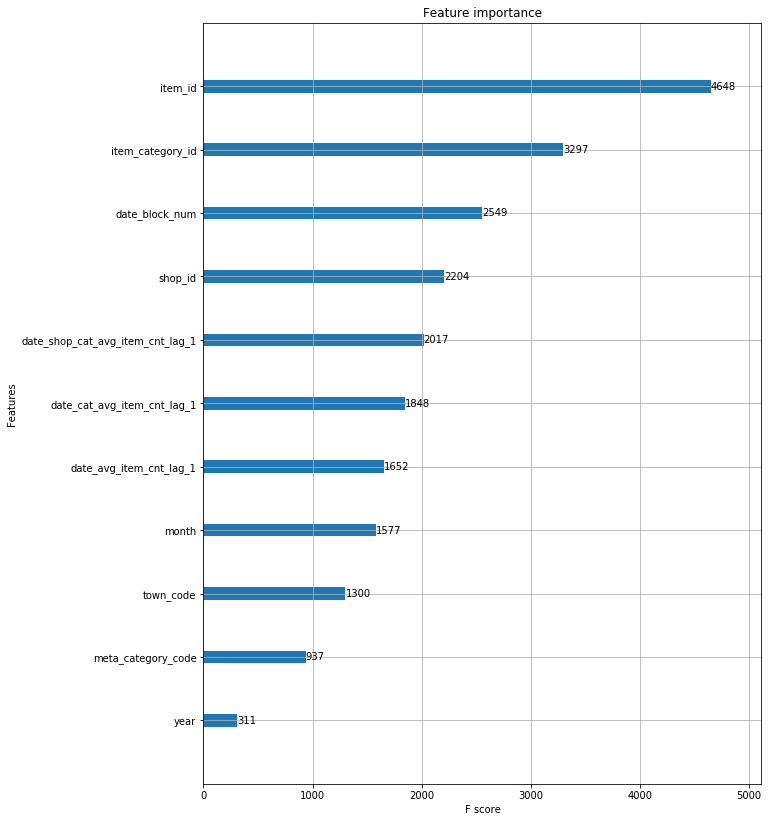

In [32]:
plot_features(model, (10,14))